In [20]:
%load_ext Cython
# https://kaushikghose.wordpress.com/2014/12/08/get-more-out-of-cython/
# http://nealhughes.net/cython1/
# http://codereview.stackexchange.com/questions/43413/optimize-cython-code-with-np-ndarray-contained
# https://github.com/bendmorris/pybioclim/blob/master/src/coords.pyx
%matplotlib inline

import math
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import gmplot
from datetime import datetime, timezone, timedelta
import os, re, sys
from itertools import compress
from numba import vectorize, guvectorize, jit, autojit, float32, float64, double, int64, int32

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# This is a demo for pre-processing mobile accelerometer data
#### Date:  Mar 2017

In [30]:
ROLLING_WINDOW_SIZE = 10
ROLLING_WINDOW_SECONDS = 10.
# http://www.latlong.net/lat-long-utm.html

GPS_DATA_COLUMNS = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gps_accuracy', 
                    'gps_bearing', 'gps_height', 'gps_lat', 'gps_lon', 'gps_speed']

TRIP_START_SPEED_KPH = 8.

#gpsdf = pd.read_csv('../data_FLOOW/1616D3D1-AC92-4C0D-B46A-39D75CDBBC7E.201308210454540000.csv',index_col=False)
gpsdf = pd.read_csv('../data_FLOOW/1D2DC1C0-992E-417A-A7FF-C631CD255162.201309050539130000.csv',index_col=False)
#gpsdf = pd.read_csv('../data_FLOOW/b93de778-3a31-4e4e-8026-0cb87443976c.19sep2013170729.csv',index_col=False)
gpsdf['timestamp'] = gpsdf['timestamp'].astype(np.float64)
gpsdf['timestamp'] = gpsdf['timestamp'] / 1000.

/Users/mpeng/anaconda/envs/dev36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
# check if the new gps data data frames have all column names as specified in
# the gps_data_columns
if not set(GPS_DATA_COLUMNS).issubset(set(gpsdf.columns.values)):
    error = "The columns not found in the gps data frame are: {}".format( \
             ", ".join(list(set(GPS_DATA_COLUMNS) - set(gpsdf.columns.values))))
    raise Exception(error)

In [23]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, columns_to_plot=['acc_x', 'acc_y', 'acc_z']):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['timestamp'], activity[columns_to_plot[0]], columns_to_plot[0])
    plot_axis(ax1, activity['timestamp'], activity[columns_to_plot[1]], columns_to_plot[1])
    plot_axis(ax2, activity['timestamp'], activity[columns_to_plot[2]], columns_to_plot[2])
    plt.subplots_adjust(hspace=0.2)
    plt.show()


def magnitude(activity):
    # the operation is on the pandas data frame
    x2 = activity['acc_x'] * activity['acc_x']
    y2 = activity['acc_y'] * activity['acc_y']
    z2 = activity['acc_z'] * activity['acc_z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m


def plot_magnitude(activity):
    fig, (ax0) = plt.subplots(nrows=1, figsize=(15, 10), sharex=True)
    plot_axis(ax0, activity['timestamp'], magnitude(acc_activity), 'Magnitude')
    plt.subplots_adjust(hspace=0.2)
    plt.show()


def select_start_end_trip(df,
                          speed_column = "gps_speed",
                          meta_col_prefix ="metadata",
                          trip_start_speed = TRIP_START_SPEED_KPH):
    # Select the data frame rows that have reasonable speed values before it stops
    regex = re.compile(meta_col_prefix+".")
    l = list(df.columns.values)
    matches = [string for string in l if re.match(regex, string)]
    if matches:
        for col in matches:
            # to refill all NA values of metadata, this is for future indexing
            x = df[:10]
            df[col] = x[~pd.isnull(x[col])][col].values[0]
    try:
        last_pos_spd_idx = np.max(np.asarray(df[df[speed_column] >0].index))
    except ValueError:
        last_pos_spd_idx = np.min(np.asarray(df.index))
    try:
        last_zero_spd_idx = np.max(np.asarray(df[df[speed_column] ==0].index))
    except ValueError:
        last_zero_spd_idx = np.min(np.asarray(df.index))
    if last_pos_spd_idx >= last_zero_spd_idx:
        last_idx = last_pos_spd_idx
    else:
        gpsdf_sub = df.ix[(last_pos_spd_idx+1):]
        try:
            last_idx = np.min(np.asarray(gpsdf_sub[gpsdf_sub[speed_column]==0].index))
        except ValueError:
            last_idx = last_pos_spd_idx
    trip_start_speed_ms = trip_start_speed / 3.6
    start_indx = np.min(np.asarray(df[df[speed_column] >= trip_start_speed_ms].index))
    df = df.ix[start_indx:np.min([np.max(np.asarray(df.index)),last_idx])]
    return df


def cal_acceleration(df, speed_col, time_col, new_col_name, plot=True):
    """calculate the accleration for given data frame
    Args:
        df: pandas data frame with the speed, timestamp columsn to calculate the acceleration
        speed_col: speed column name, in m/s
        time_col: timestamp column name, in second
        new_col_name: the new acceleration column name to be created
    Examples:
    --------
        >>> speed_col = "gps_speed"
        >>> time_col = "timestamp"
        >>> new_col_name = "acc_forward"
    """
    speed_delta = df[speed_col] - df[speed_col].shift(1)
    time_delta = df[time_col] - df[time_col].shift(1)
    if plot: time_delta.plot.hist(alpha=0.5, bins=40, legend=True)
    df[new_col_name] = 0.101972 * speed_delta / time_delta  # conert m/s2 to g
    df[new_col_name] = df[new_col_name].fillna(df[new_col_name].iloc[1])
    return df


def cal_acceleration_by_distance(df, position_col, time_col, new_col_name):
    """calculate the accleration for given data frame
    Args:
        df: pandas data frame with the altitude, timestamp columsn to calculate the acceleration
        position_col: the column name with relative position, such as altitude, in meter
        time_col: timestamp column name, in second
        new_col_name: the new acceleration column name to be created, downward direction gives negative value,
            here, its value removes the gravity if it's downward
    Examples:
    --------
        >>> position_col = "gps_height"
        >>> time_col = "timestamp"
        >>> new_col_name = "acc_upward"
    """
    dist_delta = df[position_col] - df[position_col].shift(1)
    time_delta = df[time_col] - df[time_col].shift(1)
    dist_delta = df[position_col] - df[position_col].shift(1)
    time_delta = df[time_col] - df[time_col].shift(1)
    speed = dist_delta/time_delta
    speed_delta = speed - speed.shift(1)
    acc = 0.101972 * speed_delta / time_delta  # conert m/s2 to g
    acc = acc.fillna(acc.iloc[2])
    df[new_col_name] = acc  # remove the gravity
    return df


def create_acc_features(gpsdf,
                       speed_column = "gps_speed",
                       height_column = "gps_height",
                       lat_lon_columns = ["gps_lat", "gps_lon"],
                       timestamp_column = "timestamp"):
    """calculate the accleration for given data frame
    Args:
        gpsdf: pandas data frame with the altitude, timestamp columsn to calculate the acceleration
    """
    df = gpsdf.copy()  # just make a copy to avoid issue with warnings
    df['entry_index'] = 0
    df.ix[~pd.isnull(df[speed_column]), "entry_index"] = 1
    df['entry_index'] = df['entry_index'].shift(1)
    df['entry_index'] = df['entry_index'].fillna(0)
    df['entry_index'] = df['entry_index'].cumsum()
    # timestamp_earliest = gpsdf.groupby(['entry_index'])['timestamp'].min()
    # gpsdf = gpsdf.join(gpsdf.groupby('entry_index')['timestamp'].min(), on='entry_index', rsuffix='_last_speed')
    gpsdf_sec0 = df[~pd.isnull(df[[speed_column]]).any(axis=1)]
    gpsdf_sec = gpsdf_sec0.copy()
    gpsdf_sec = cal_acceleration(gpsdf_sec, speed_column, timestamp_column, "acc_forward", plot=True)
    gpsdf_sec = cal_acceleration_by_distance(gpsdf_sec, height_column, timestamp_column, "acc_upward")
    gpsdf_sec['gps_speed_kph'] = gpsdf_sec['gps_speed'] * 3.6
    return gpsdf_sec

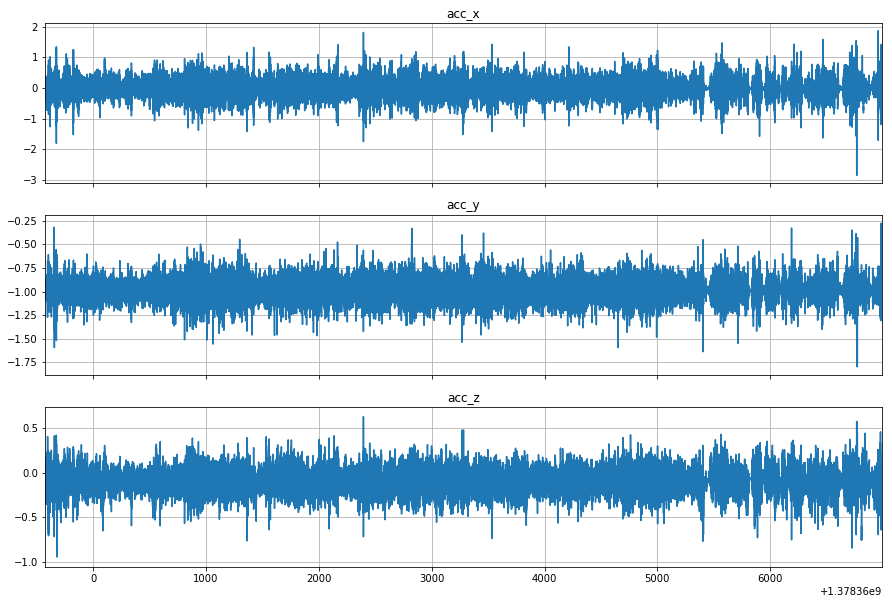

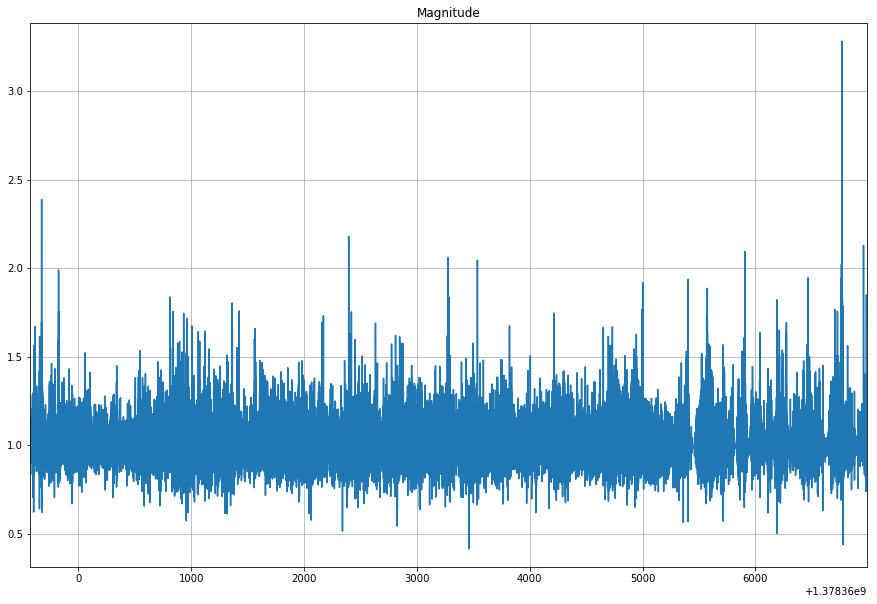

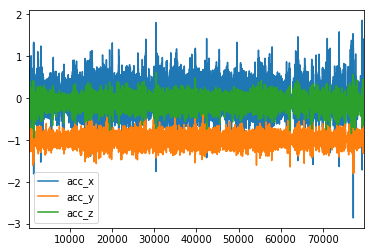

In [24]:
gpsdf = select_start_end_trip(gpsdf, speed_column = "gps_speed")
# select only non-null gps acc_x,y,z data
acc_activity = gpsdf.ix[~pd.isnull(gpsdf[["acc_x","acc_y", "acc_z"]]).any(axis=1), ["timestamp","acc_x","acc_y", "acc_z"]]
plot_activity(acc_activity, columns_to_plot=['acc_x', 'acc_y', 'acc_z'])
plot_magnitude(acc_activity)
# plot accelerometer signal = gravity + user acceleration
acc_activity[['acc_x', 'acc_y', 'acc_z']].plot()

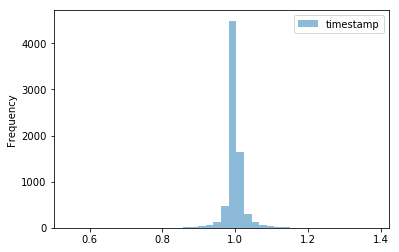

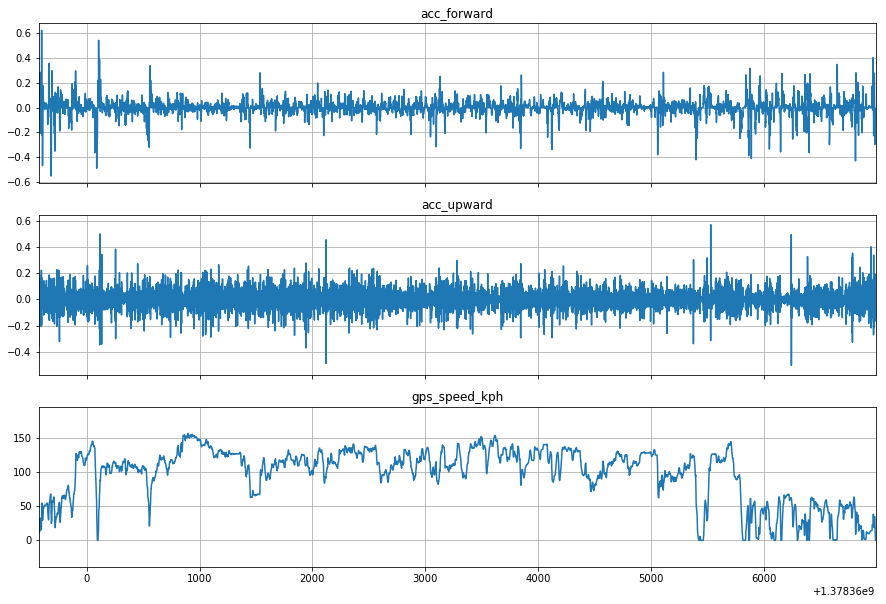

In [25]:
gpsdf_sec = create_acc_features(gpsdf)
plot_activity(gpsdf_sec, columns_to_plot=['acc_forward', 'acc_upward', 'gps_speed_kph'])

In [32]:
# add export GOOGLE_API_KEY=AI. to the ~/.bash_profile
# gmaps.configure(api_key=os.environ['GOOGLE_API_KEY'])
locations = gpsdf_sec[["gps_lat", "gps_lon"]]
#locations = [x for x in zip(locations.values[:,0], locations.values[:,1])]
# add export GOOGLE_API_KEY=AI. to the ~/.bash_profile
gmap = gmplot.GoogleMapPlotter(locations.values[0,0], locations.values[0,1],16)
gmap.plot(locations.values[:,0], locations.values[:,1], 'cornflowerblue', edge_width=4)
gmap.draw("test_trip_map.html")